# Node elevations and edge grades

Author: [Geoff Boeing](https://geoffboeing.com/)

  - [Overview of OSMnx](http://geoffboeing.com/2016/11/osmnx-python-street-networks/)
  - [GitHub repo](https://github.com/gboeing/osmnx)
  - [Examples, demos, tutorials](https://github.com/gboeing/osmnx-examples)
  - [Documentation](https://osmnx.readthedocs.io/en/stable/)
  - [Journal article/citation](http://geoffboeing.com/publications/osmnx-complex-street-networks/)

You will need a Google Maps Elevation API key from https://developers.google.com/maps/documentation/elevation/start

Consider your API usage limits. OSMnx rounds coordinates to 5 decimal places (approx 1 meter) to fit 350 locations in a batch.
  
Note that there is some spatial inaccuracy given Google's dataset's resolution. For example, in San Francisco (where the resolution is 19 meters) a couple of edges in hilly parks have a 50+ percent grade because Google assigns one of their nodes the elevation of a hill adjacent to the street.

In [1]:
from keys import google_elevation_api_key #replace this with your own API key!
import networkx as nx
import numpy as np
import osmnx as ox
ox.config(log_console=True, use_cache=True)
ox.__version__

'0.13.0'

In [2]:
# get the street network for san francisco
place = 'San Francisco'
place_query = {'city':'San Francisco', 'state':'California', 'country':'USA'}
G = ox.graph_from_place(place_query, network_type='drive')

In [3]:
# add elevation to each of the nodes, using the google elevation API, then calculate edge grades
G = ox.add_node_elevations(G, api_key=google_elevation_api_key)
G = ox.add_edge_grades(G)

## Calculate some summary stats

Use an undirected representation of the network so we don't overcount two-way streets (because they have reciprocal edges pointing in each direction). We use the absolute value of edge grade because we're interested in steepness, not directionality.

In [4]:
edge_grades = [data['grade_abs'] for u, v, k, data in ox.get_undirected(G).edges(keys=True, data=True)]

In [5]:
avg_grade = np.mean(edge_grades)
print('Average street grade in {} is {:.1f}%'.format(place, avg_grade*100))

med_grade = np.median(edge_grades)
print('Median street grade in {} is {:.1f}%'.format(place, med_grade*100))

Average street grade in San Francisco is 4.0%
Median street grade in San Francisco is 2.6%


## Plot the nodes by elevation

Plot them colored from low (violet) to high (yellow).

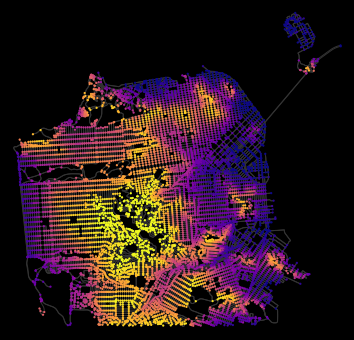

In [6]:
# get one color for each node, by elevation, then plot the network
nc = ox.plot.get_node_colors_by_attr(G, 'elevation', cmap='plasma', num_bins=20)
fig, ax = ox.plot_graph(G, node_color=nc, node_size=5, node_zorder=2,
                        edge_color='#333333', bgcolor='k')

## Plot the edges by grade

Grade is the ratio of elevation change to edge length. Plot edges colored from low/flat (violet) to high/steep (yellow).

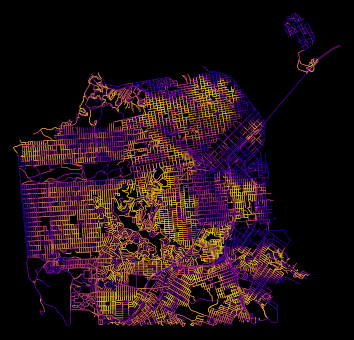

In [7]:
# get a color for each edge, by grade, then plot the network
ec = ox.plot.get_edge_colors_by_attr(G, 'grade_abs', cmap='plasma', num_bins=100)
fig, ax = ox.plot_graph(G, fig_height=6, edge_color=ec, edge_linewidth=0.5, node_size=0, bgcolor='k')

## Calculate shortest paths, considering grade impedance

This example approximates the route of "The Wiggle" in San Francisco.

In [8]:
# select an origin and destination node and a bounding box around them
origin = ox.get_nearest_node(G, (37.77, -122.426))
destination = ox.get_nearest_node(G, (37.773, -122.441))
bbox = ox.utils_geo.bbox_from_point((37.772, -122.434), dist=1500)

In [9]:
# define some edge impedance function here
def impedance(length, grade):
    penalty = grade ** 2
    return length * penalty

# add impedance and elevation rise values to each edge in the projected graph
# use absolute value of grade in impedance function if you want to avoid uphill and downhill
for u, v, k, data in G.edges(keys=True, data=True):
    data['impedance'] = impedance(data['length'], data['grade_abs'])
    data['rise'] = data['length'] * data['grade']

#### First find the shortest path that minimizes *trip distance*:

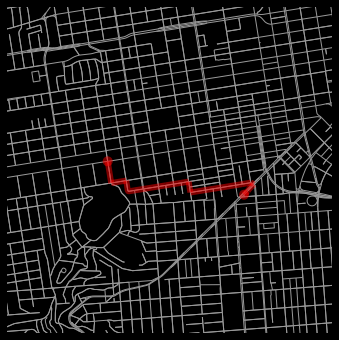

In [10]:
route_by_length = nx.shortest_path(G, source=origin, target=destination, weight='length')
fig, ax = ox.plot_graph_route(G, route_by_length, bbox=bbox,
                              route_linewidth=6, node_size=0, bgcolor='k')

#### Now find the shortest path that avoids slopes by minimizing *impedance* (function of length and grade):

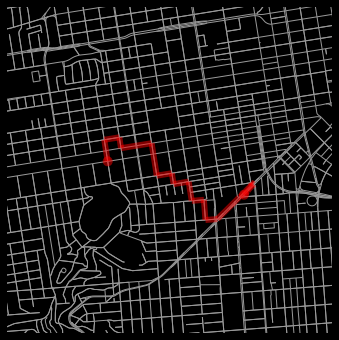

In [11]:
route_by_impedance = nx.shortest_path(G, source=origin, target=destination, weight='impedance')
fig, ax = ox.plot_graph_route(G, route_by_impedance, bbox=bbox,
                              route_linewidth=6, node_size=0, bgcolor='k')

#### Print some summary stats about these two routes:

In [12]:
def print_route_stats(route):
    route_grades = ox.utils_graph.get_route_edge_attributes(G, route, 'grade_abs')
    msg = 'The average grade is {:.1f}% and the max is {:.1f}%'
    print(msg.format(np.mean(route_grades)*100, np.max(route_grades)*100))

    route_rises = ox.utils_graph.get_route_edge_attributes(G, route, 'rise')
    ascent = np.sum([rise for rise in route_rises if rise >= 0])
    descent = np.sum([rise for rise in route_rises if rise < 0])
    msg = 'Total elevation change is {:.0f} meters: a {:.0f} meter ascent and a {:.0f} meter descent'
    print(msg.format(np.sum(route_rises), ascent, abs(descent)))

    route_lengths = ox.utils_graph.get_route_edge_attributes(G, route, 'length')
    print('Total trip distance: {:,.0f} meters'.format(np.sum(route_lengths)))

In [13]:
# stats of route minimizing length
print_route_stats(route_by_length)

The average grade is 4.7% and the max is 13.0%
Total elevation change is 31 meters: a 69 meter ascent and a 38 meter descent
Total trip distance: 1,908 meters


In [14]:
# stats of route minimizing impedance (function of length and grade)
print_route_stats(route_by_impedance)

The average grade is 2.1% and the max is 5.7%
Total elevation change is 31 meters: a 42 meter ascent and a 12 meter descent
Total trip distance: 2,748 meters


So, we decreased the average slope along the route from a 5% grade to a 2% grade. The total elevation change is obviously the same with either route, but using our impedance function we decrease the total ascent from 69 meters to 42 meters (but the trip distance increases from 1.9 km to 2.7 km).